In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from dataset_generation import generate_dataset, sm_generative_model
from wassa_plots import plot_SM, plot_colored_raster

# Generative model for raster plots and spiking motifs

List of parameters for this generative model

In [3]:
class dataset_parameters():
    seed = 666
    
    N_pre = 100 # number of neurons
    N_timesteps = 1000 # number of timesteps for the raster plot (in ms)
    N_samples = 100

    N_delays = 51 # number of timesteps in spiking motifs, must be a odd number for convolutions
    N_SMs = 5 # number of structured spiking motifs
    N_involved = N_pre*torch.ones(N_SMs) # number of neurons involved in the spiking motif
    avg_fr = 40 # average firing rate of the neurons (in Hz)
    std_fr = 1 # standard deviation for the firing rates of the different neurons
    frs = torch.normal(avg_fr, std_fr, size=(N_pre,)).abs()
    freq_sms = 1*torch.ones(N_SMs) # frequency of apparition of the different spiking motifs (in Hz)
    overlapping_sms = False # possibility to have overlapping sequences
    coefficient_variation = torch.ones(N_pre)*10

    temporal_jitter = .1 # temporal jitter for the spike generation in motifs
    dropout_proba = .5 # probabilistic participations of the different neurons to the spiking motif
    additive_noise = .1 # percentage of background noise/spontaneous activity
    warping_coef = 2 # coefficient for time warping

    def get_parameters(self):
        return f'{self.N_pre}_{self.N_delays}_{self.N_SMs}_{self.N_timesteps}_{self.N_involved.mean()}_{self.avg_fr}_{self.freq_sms.mean()}_{self.overlapping_sms}_{self.temporal_jitter}_{self.dropout_proba}_{self.additive_noise}_{self.warping_coef}_{self.seed}'

#torch.serialization.add_safe_globals([dataset_parameters])

In [4]:
sm = sm_generative_model(dataset_parameters)

The generative model will draw raster plots generated from both a spontaneous (random) activity and from spiking motifs. There are *parameters.N_SM* spiking motifs represented in the next plot. There are given as a spiking probability for each presynatpic neuron and each timestep (or delay). 

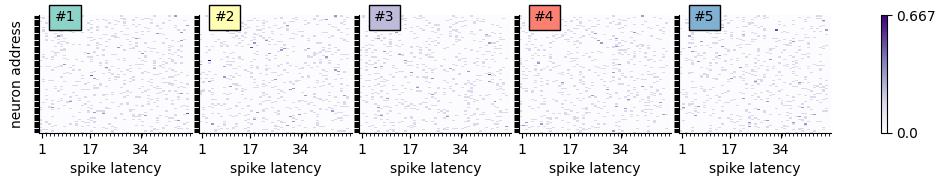

In [5]:
plot_SM(sm.SMs);

The raster plot is produced with a sequence of apparition of the different motifs and random activity when no motif occurs. 

In [8]:
number_of_trials = 1000
input_rp, output_rp = sm.draw_input(nb_trials=number_of_trials)

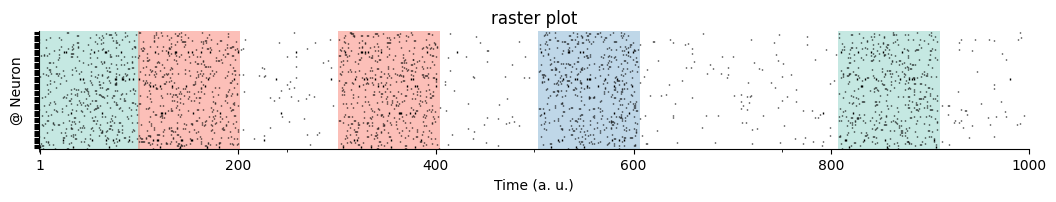

In [9]:
plot_colored_raster(input_rp, output_rp, dataset_parameters);

The not structured spiking activity of the different neurons is given by their FRs (*parameters.frs*). Then, it is given by the occurence of a motif (colored parts of the raster plot) and the structure of the motif. The occurence of a motif is given by a random trial defining its timing and its type (or color).  

The raster plot is obtained with a Bernoulli trial on the probability distribution representing the non structured (flat distribution) or the structured (probability distributions of the different motifs). When motifs overlap the formula used to merge the motifs and obtain the expected raster plot is the following: 
$$Bernoulli(p) + Bernoulli(q) = Bernoulli(p+q-p*q)$$

It leads to Poisson distribution with an expected number of spike during the trial and their relative temporal dependencies that can vary with the number of motifs, their frequency of apparition (*parameters.freq_sm*) or the number of neurons involved in the motif (*parameters.N_involved*)

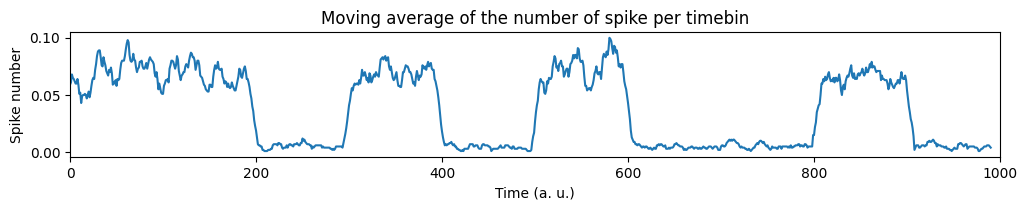

In [10]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
    
fig, ax = plt.subplots(figsize = (12, 1.61803))
ax.plot(moving_average(input_rp[0].mean(axis=(0)),10))
ax.set_xlim(0, dataset_parameters.N_timesteps)
ax.set_xlabel('Time (a. u.)')
ax.set_ylabel('Spike number')
ax.set_title('Moving average of the number of spike per timebin');

The instantaneous firing rate sumed over the different trials shows that the distribution is Poisson. And we can check the effective number of spikes per neuron compared to the expected firing rate. Firing rate of the different neurons can be easily changed, default is chosen by following a normal distribution around an average firing rate.  

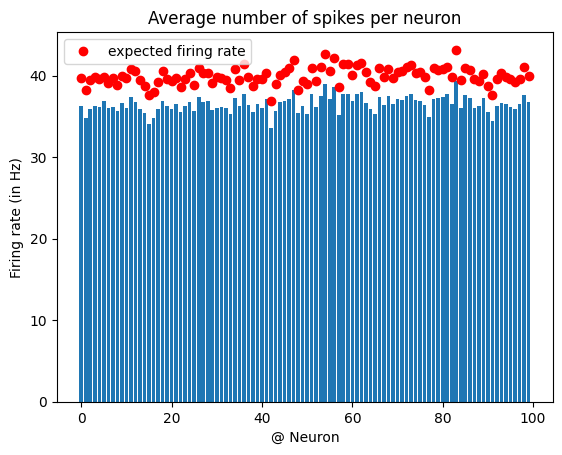

In [11]:
fig, ax = plt.subplots()
ax.bar(np.arange(dataset_parameters.N_pre),1e3*input_rp.mean(axis=(0,2)))
ax.plot(dataset_parameters.frs, 'ro', label='expected firing rate')
ax.set_xlabel('@ Neuron')
ax.set_ylabel('Firing rate (in Hz)')
ax.legend();
ax.set_title('Average number of spikes per neuron');

We can also check the number of occurence of the motifs and compare it to the expected number of occurence.

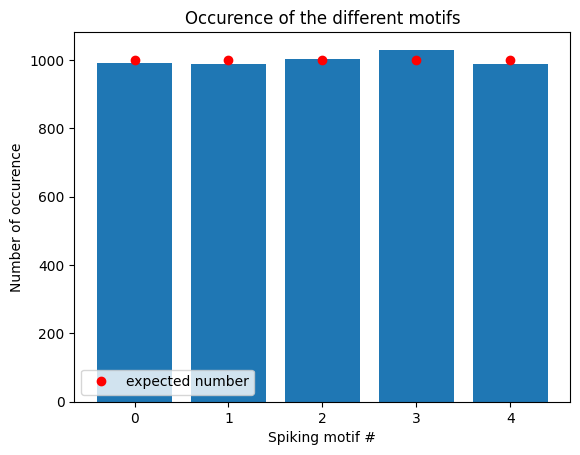

In [12]:
fig, ax = plt.subplots()
ax.bar(np.arange(dataset_parameters.N_SMs),output_rp.sum(axis=(0,2)))
ax.plot(dataset_parameters.freq_sms*number_of_trials, 'ro', label='expected number')
ax.set_xlabel('Spiking motif #')
ax.set_ylabel('Number of occurence')
ax.set_title('Occurence of the different motifs');
ax.legend();

## No overlap of the motifs

If you set the following parameter to False, then the overlap of the motifs is prevented. 

In [13]:
sm.opt.overlapping_sms = False
input_rp, output_rp = sm.draw_input(nb_trials=100)

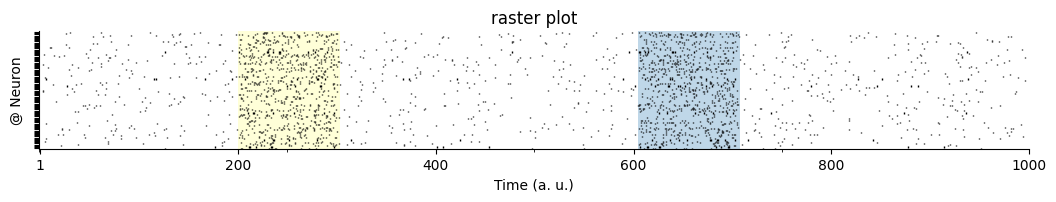

In [14]:
plot_colored_raster(input_rp, output_rp, dataset_parameters);

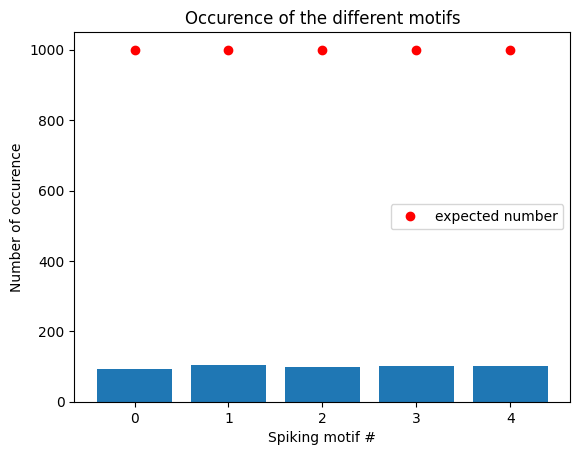

In [15]:
fig, ax = plt.subplots()
ax.bar(np.arange(dataset_parameters.N_SMs),output_rp.sum(axis=(0,2)))
ax.plot(dataset_parameters.freq_sms*number_of_trials, 'ro', label='expected number')
ax.set_xlabel('Spiking motif #')
ax.set_ylabel('Number of occurence')
ax.set_title('Occurence of the different motifs');
ax.legend();

## Save a dataset

You can also easily save a dataset with a defined number of trials (*total_number_of_trials*). It will split the dataset into a training (80% of the trials) and a testing (20% of the trials) of the trials sets. 

In [16]:
total_number_of_trials = 1000
sm, trainset_input, trainset_output, testset_input, testset_output = generate_dataset(dataset_parameters, record_path = './synthetic_data/')

./synthetic_data/synthetic_rp_trainset_50_100_51_5_1000_100.0_40_1.0_False_0.1_0.5_0.1_2_666.pt
./synthetic_data/synthetic_rp_testset_50_100_51_5_1000_100.0_40_1.0_False_0.1_0.5_0.1_2_666.pt


/home/antoine/Documents/cosyne-brainchack/dataset_generation.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sm = torch.load(model_path, map_location=device)#, weights

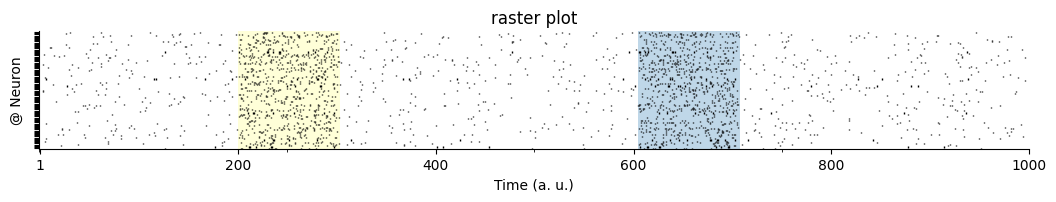

In [17]:
plot_colored_raster(input_rp, output_rp, dataset_parameters);

## Alteration of the motifs

There are different types of noise that can be added to the motifs: 
- temporal jitter: the timing of a spiking can be shifted in time. It is modeled by convolving the precise spiking motifs with a gaussian kernel (its standard deviation (*parameters.temporal_jitter*) gives the amount of jitter).
- stochatistic activation of the neurons: neurons can also not participate in the generation of a spike at a specific spatio temporal location. This participation is obtained with a random trial on which neurons will be activated with a probability of activation for each neuron (*parameters.dropout_proba*)
- additive noise: percentage of background activity given by (*parameters.additive_noise*).
- time warping: the kernel is streched in time with a specific coefficient (*parameters.warping_coef*) 

Because we maintain a constant firing rates for the different trials and the way the generative model is defined, these types of alteration will occur only at the motif level and then, a background activity of 100% leads to the same type of unstructured activity as a dropout probability of 1 for each of the neurons or an infinite temporal jitter. 

## Improvement directions:
- there are still some discrepancies between real statistics and the one obtained
- the coefficient by which the coefficient of variation is multiplied does not directly rely to true statistics, find a better one (depends of course on the size of the kernel etc)